In [91]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [92]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [93]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [94]:
diabetes.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


In [95]:
X = diabetes.drop(['Diabetic', 'PatientID'], axis=1).copy()
y = diabetes['Diabetic'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [96]:
X_train

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age
10691,10,101,99,45,66,23.625555,0.179501,21
6152,8,116,84,11,55,35.798325,0.203872,21
7016,1,117,53,41,42,18.666434,0.159149,22
8035,3,113,94,24,59,33.038855,0.115565,60
11491,7,138,57,7,237,18.864558,0.241194,23
...,...,...,...,...,...,...,...,...
2544,2,65,81,52,231,37.188336,0.156634,44
8758,0,132,57,9,20,20.668310,0.169872,22
2383,0,101,60,33,156,38.641082,0.240418,23
772,1,170,59,15,65,36.384186,0.702569,23


In [97]:
num_features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'Age']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['Pregnancies',
                                                   'PlasmaGlucose',
                                                   'DiastolicBloodPressu

In [98]:
scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)
model_lr = LogisticRegression()
model_lr.fit(X_train_standardized, y_train)

LogisticRegression()

In [99]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      2500
           1       0.74      0.55      0.63      1250

    accuracy                           0.79      3750
   macro avg       0.77      0.73      0.74      3750
weighted avg       0.78      0.79      0.78      3750



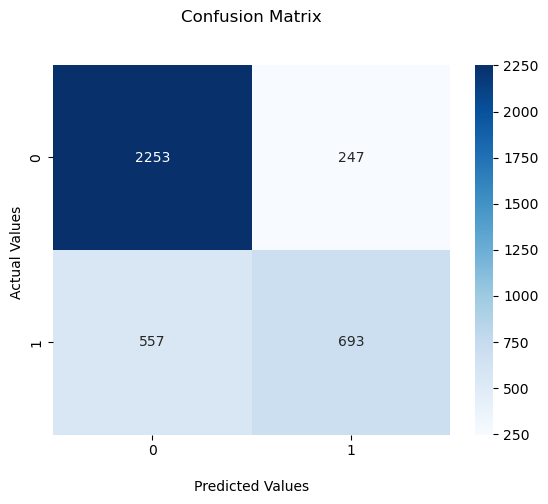

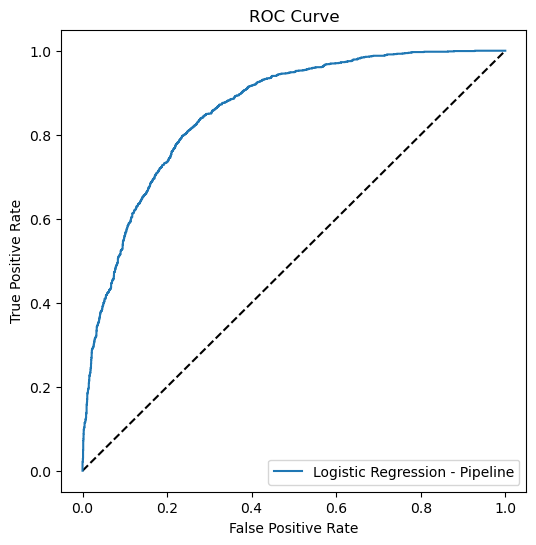

C:\Users\Admin\AppData\Local\Temp\ipykernel_10460\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression - Pipeline,0.632877,0.85857


In [100]:
calculate_metrics(model_pipeline, 'Logistic Regression - Pipeline', X_test, y_test)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2500
           1       0.72      0.60      0.65      1250

    accuracy                           0.79      3750
   macro avg       0.77      0.74      0.75      3750
weighted avg       0.78      0.79      0.78      3750



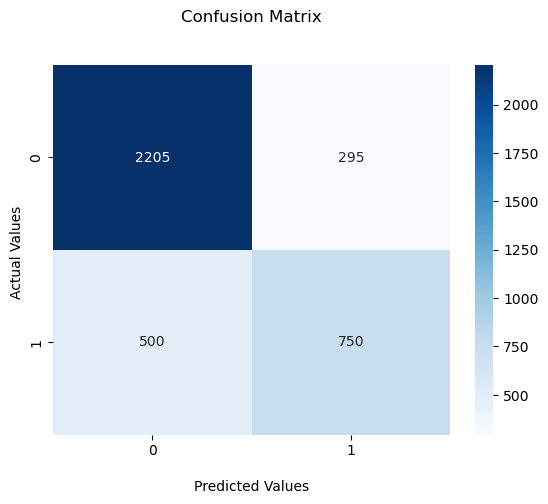

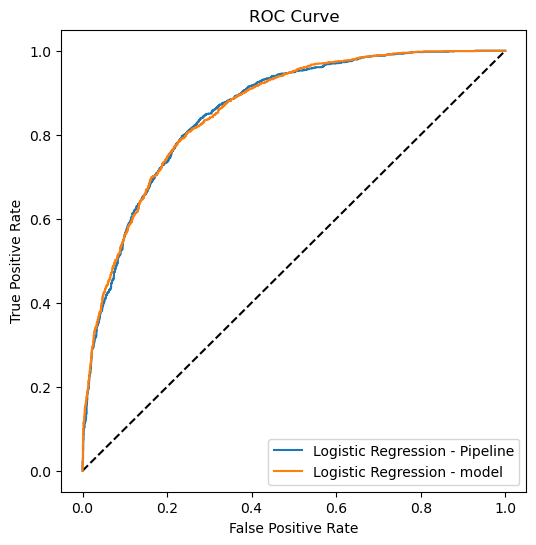

C:\Users\Admin\AppData\Local\Temp\ipykernel_10460\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression - Pipeline,0.632877,0.858570
1,Logistic Regression - model,0.653595,0.859502


In [101]:
calculate_metrics(model_lr, 'Logistic Regression - model', X_test_standardized, y_test)

### <font color="green">Wynik jest dość ciekawy i zaskakujący. Wygląda na to, że straciliśmy w pipielinie na czułości bądź precyzji, separacja wygląda na identyczną. Wydaje mi się, że może mieć na to wpływ fakt, że dodatkowo dokonywane są transformacje (PCA i Polynomial Features). Jestem ciekaw jak to wypadnie po dobraniu parametrów przy GridSearchCV.

In [102]:
num_features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'Age']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('scaler_1', StandardScaler())
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('scaler_1',
                                                                   StandardScaler())]),
                                                  ['Pregnancies',
                                                   'PlasmaGlucose',
                                                   'DiastolicBloodPressure',
                                                   'TricepsThickness',
                                                   'SerumInsulin', 'BMI',
                                                   'Age'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2500
           1       0.70      0.58      0.63      1250

    accuracy                           0.78      3750
   macro avg       0.75      0.73      0.74      3750
weighted avg       0.77      0.78      0.77      3750



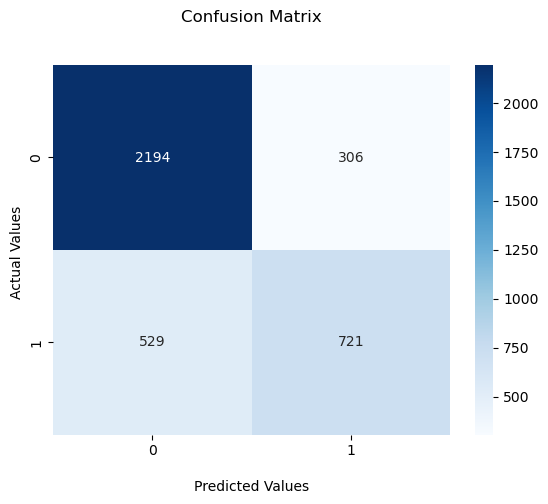

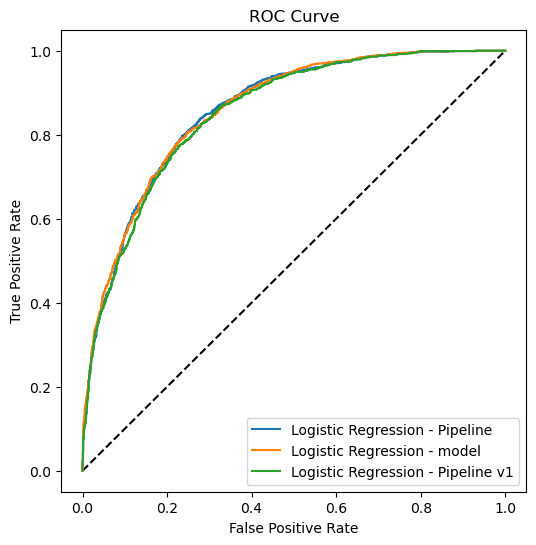

C:\Users\Admin\AppData\Local\Temp\ipykernel_10460\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression - Pipeline,0.632877,0.858570
1,Logistic Regression - model,0.653595,0.859502
2,Logistic Regression - Pipeline v1,0.633289,0.852683


In [104]:
calculate_metrics(model_pipeline_v1, 'Logistic Regression - Pipeline v1', X_test, y_test)

### <font color="green">?? Czemu jest różnica w F1_score ??